In [1]:
import os

import clip
import numpy as np
import PIL.Image
import torch

from embedding import get_delta_t
from manipulator import Manipulator
from mapper import get_delta_s
from wrapper import Generator

/opt/conda/lib/python3.8/site-packages/clip/clip.py:24: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [2]:
# GPU device
device = torch.device('cuda:1')
# pretrained ffhq generator
ckpt = 'pretrained/ffhq.pkl'
G = Generator(ckpt, device)
# CLIP
model, preprocess = clip.load("ViT-B/32", device=device)
# global image direction
fs3 = np.load('tensor/fs3.npy')

In [3]:
manipulator = Manipulator(G, device)

In [4]:
# test image dir path
imgdir = 'samples'

In [5]:
# manipulator mode
# inv_mode : inversion mode
    # 'w' : use w projector proposed by Karras et al.
    # 'w+' : use e4e encoder (only implemented for ffhq1024 now)
# pti_mode : pivot tuning mode
    # 'w' : W latent space pivot tuning
    # 's' : Style space pivot tuning
manipulator.set_real_img_projection(imgdir, inv_mode='w+', pti_mode='s')

Loading e4e over the pSp framework from checkpoint: pretrained/e4e_ffhq_encode.pt
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Loading e4e over the pSp framework from checkpoint: pretrained/e4e_ffhq_encode.pt
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


  0%|                                                   | 0/350 [00:00<?, ?it/s]

Loading model from: /opt/conda/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


100%|█████████████████████████████████████████| 350/350 [08:36<00:00,  1.47s/it]


In [6]:
# prompt engineering
templates = [
    'a bad photo of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'a low resolution photo of a {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a photo of a nice {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a good photo of a {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a dark photo of a {}.',
    'graffiti of the {}.',
]

In [7]:
# text direction : neutral -> target
neutral = 'young face'
target = 'old face'

# beta_threshold : Determines the degree of disentanglement, # channels manipulated
beta_threshold = 0.10

In [8]:
classnames=[neutral, target]
# get delta_t in CLIP text space
delta_t = get_delta_t(classnames, model)
# get delta_s in global image directions and text directions that satisfy beta threshold
delta_s, num_channel = get_delta_s(fs3, delta_t, manipulator, beta_threshold=beta_threshold)
print(f'{num_channel} channels will be manipulated under the beta threshold {beta_threshold}')

657 channels will be manipulated under the beta threshold 0.1


In [9]:
# alpha_threshold : Determines the degree of manipulation
lst_alpha = [-2, -1, 0, 1, 2]
manipulator.set_alpha(lst_alpha)

In [10]:
# manipulate styles
styles = manipulator.manipulate(delta_s)

In [11]:
# synthesis images from manipulated styles
all_imgs = manipulator.synthesis_from_styles(styles, 0, manipulator.num_images)

-2


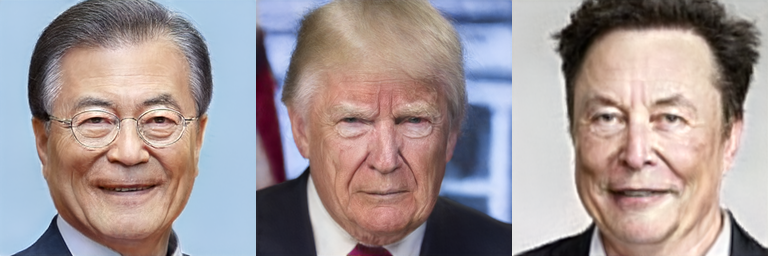

-1


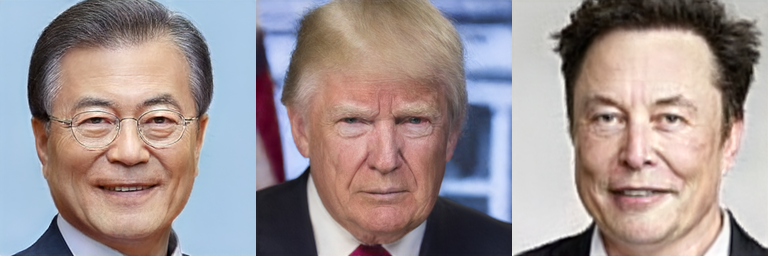

0


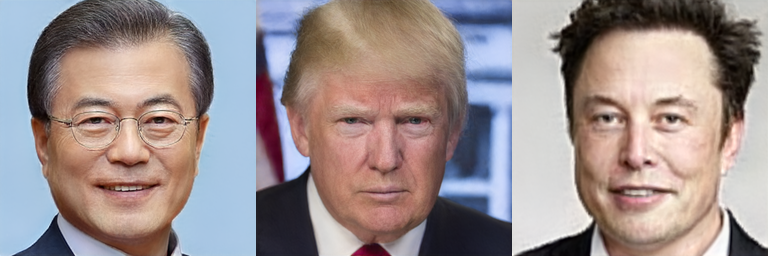

1


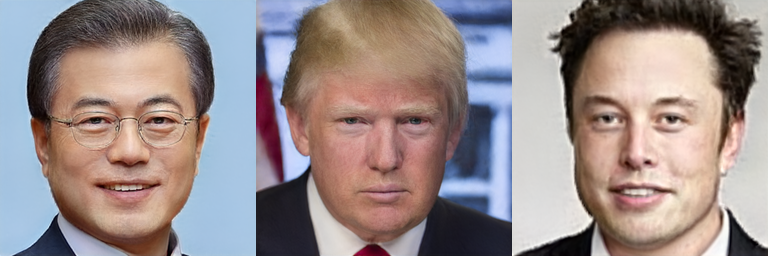

2


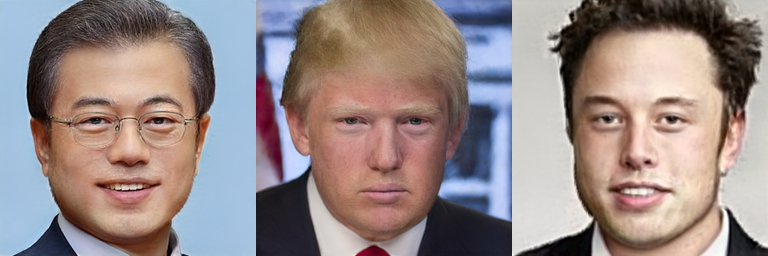

In [12]:
# visualize
lst = []
for imgs in all_imgs:
    lst.append((imgs.permute(0,2,3,1)*127.5+128).clamp(0,255).to(torch.uint8).numpy())

H,W = (256,256)
gw, gh = (manipulator.num_images, 1)

for i, alpha in enumerate(lst_alpha):
    print(alpha)
    imgs = lst[i]
    imgs_ = []    
    for img in imgs:
        imgs_.append( np.asarray( PIL.Image.fromarray(img, 'RGB').resize((H,W),PIL.Image.LANCZOS)))
    imgs_ = np.stack(imgs_)
    imgs_ = imgs_.reshape(gh,gw,H,W,3)
    imgs_ = imgs_.transpose(0,2,1,3,4)
    imgs_ = imgs_.reshape(gh*H, gw*W, 3)
    display(PIL.Image.fromarray(imgs_, 'RGB'))